## Introduction

In this project, I will utilize convolutional neural networks to detect cracks in pavement images. The dataset utilized is SDNET2018.

SDNET2018 contains over 56,000 images of cracked and non-cracked concrete bridge decks, walls, and pavements. The dataset includes cracks as narrow as 0.06 mm and as wide as 25 mm. The dataset also includes images with a variety of obstructions, including shadows, surface roughness, scaling, edges, holes, and background debris. I will use SDNET2018 for the development of concrete crack detection algorithms based on deep learning convolutional neural networks, which is a subject of continued research in the field of structural health monitoring.

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import PIL
from PIL import Image
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_datasets as tfds

## Exploratory Data Analysis

In [2]:
# Display the image folders
data_dir = '/kaggle/input/structural-defects-network-concrete-crack-images'
os.listdir(data_dir)

['Pavements', 'Decks', 'Walls']

In [3]:
deck_dir = os.path.join(data_dir, 'Decks')
pavement_dir = os.path.join(data_dir, 'Pavements')
wall_dir = os.path.join(data_dir, 'Walls')

Count the total number of pavement images and images under each category, cracked and non-cracked.

In [4]:
pavement_path = pathlib.Path(pavement_dir).with_suffix('')
ck_pavement_image = list(pavement_path.glob('Cracked/*.jpg'))
nck_pavement_image = list(pavement_path.glob('Non-cracked/*.jpg'))
pavement_image_count = len(list(pavement_path.glob('*/*.jpg')))
ck_image_count = len(ck_pavement_image)
nck_image_count = len(nck_pavement_image)
print('Total number of pavement images: ',pavement_image_count)
print('The number of cracked pavement images: ',ck_image_count)
print('The number of non-cracked pavement images',nck_image_count)

Total number of pavement images:  24334
The number of cracked pavement images:  2608
The number of non-cracked pavement images 21726


In [5]:
# Select certain number of image randomly and visualize them in single row
def img_display(img_files, num, label):
    img_sample = np.random.choice(img_files, num)
    fig, axes = plt.subplots(1, num, figsize=(4*num, 4), sharey = True)
    for i in range(num):
        img = Image.open(img_sample[i])
        axes[i].imshow(img)
        axes[i].set_title(label)
    plt.tight_layout()
    plt.show()
    return

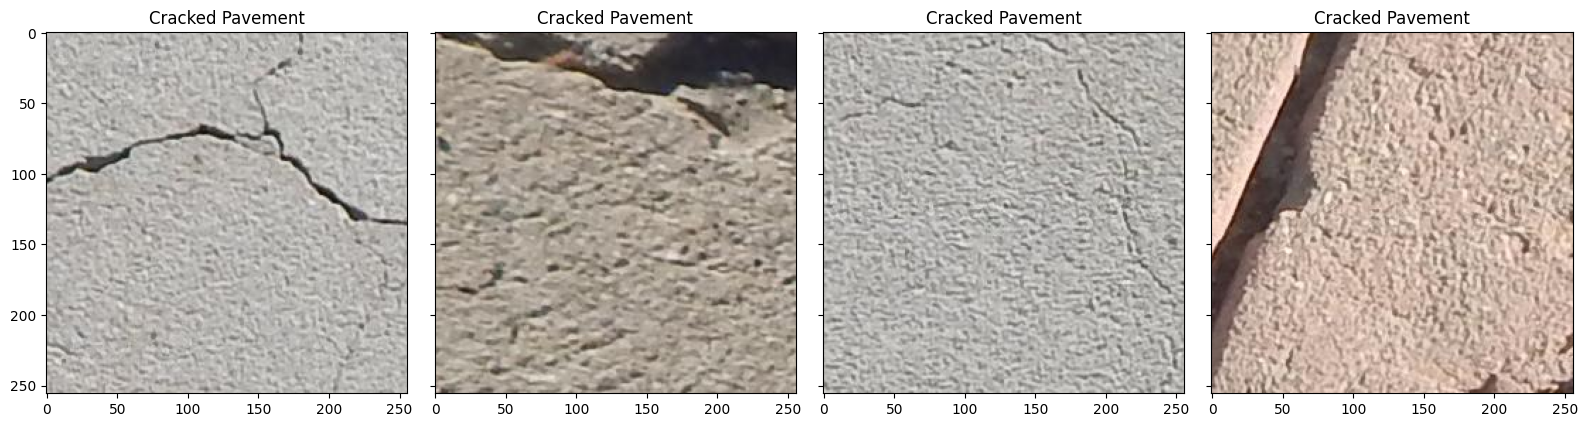

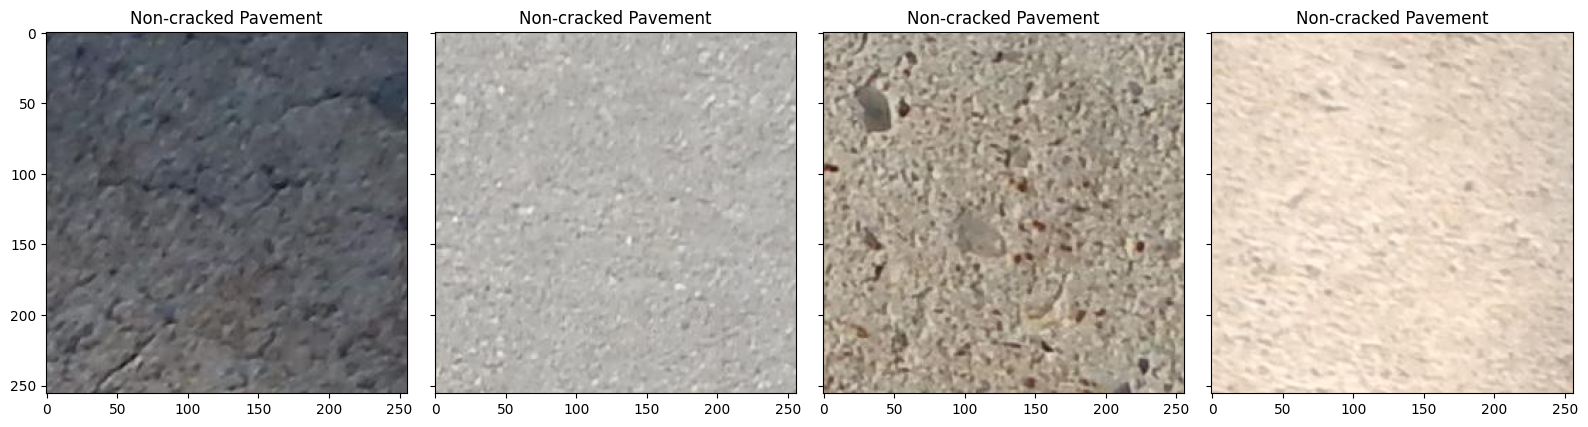

In [6]:
# Display some image samples
np.random.seed(7)
img_display(ck_pavement_image, 4, 'Cracked Pavement')
img_display(nck_pavement_image, 4, 'Non-cracked Pavement')

## Load Datasets

Generate a tf.data.Dataset from image files in a directory

In [7]:
batch_size = 16
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  pavement_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24334 files belonging to 2 classes.
Using 19468 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  pavement_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24334 files belonging to 2 classes.
Using 4866 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Cracked', 'Non-cracked']


The class_index of "Cracked" and "Non-cracked" are 0 and 1 respectively.

In [11]:
from collections import Counter

def class_count(ds):
    # class names (foler names)
    class_names = ds.class_names
    # Count samples per class
    label_counts = Counter()
    
    for image, labels in ds.unbatch():  # Unbatch to access individual labels
        label_counts[int(labels.numpy())] += 1
    # Display counts
    for class_index, count in label_counts.items():
        print(f"Class '{class_names[class_index]}' has {count} samples.")
    return label_counts

In [12]:
print('Training Dataset: ')
class_count(train_ds)
print('Validation Dataset: ')
class_count(val_ds)

Training Dataset: 
Class 'Cracked' has 2126 samples.
Class 'Non-cracked' has 17342 samples.
Validation Dataset: 
Class 'Non-cracked' has 4384 samples.
Class 'Cracked' has 482 samples.


Counter({1: 4384, 0: 482})

Both training and validation data is highly unbalanced as there are much more non-cracked images than cracked images. I will filter and balance data in the following section.

In [13]:
def balance_dataset(dataset, batch_size):
    min_count = min(class_count(dataset).values())
    # print(min_count)
    class_counts = {label: 0 for label in range(len(class_names))}
    balanced_data = []

    for images, labels in dataset.unbatch():
        label = labels.numpy()
        if class_counts[label] < min_count:
            balanced_data.append((images, labels))
            class_counts[label] += 1

        # Stop if all classes are balanced
        if all(count >= min_count for count in class_counts.values()):
            break
    # Convert to tensors
    balanced_images, balanced_labels = zip(*balanced_data)
    balanced_images = tf.convert_to_tensor(balanced_images, dtype=tf.float32)
    balanced_labels = tf.convert_to_tensor(balanced_labels, dtype=tf.int32)
    # Rebatch into a tf.data.Dataset
    balanced_dataset = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))
    # Fully shuffling all the data
    balanced_dataset = balanced_dataset.shuffle(balanced_dataset.cardinality())
    return balanced_dataset.batch(batch_size)

In [14]:
balanced_val_ds = balance_dataset(val_ds, batch_size)

val_label_counts = Counter()
for image, labels in balanced_val_ds.unbatch():  # Unbatch to access individual labels
    val_label_counts[int(labels.numpy())] += 1
print('Label counts for balanced validation dataset:',val_label_counts)

Class 'Non-cracked' has 4384 samples.
Class 'Cracked' has 482 samples.
Label counts for balanced validation dataset: Counter({1: 482, 0: 482})


In [15]:
balanced_train_ds = balance_dataset(train_ds, batch_size)

train_label_counts = Counter()
for image, labels in balanced_train_ds.unbatch():  # Unbatch to access individual labels
    train_label_counts[int(labels.numpy())] += 1
print('Label counts for balanced train dataset:', train_label_counts)

Class 'Non-cracked' has 17342 samples.
Class 'Cracked' has 2126 samples.
Label counts for balanced train dataset: Counter({1: 2126, 0: 2126})


The balanced training dataset have total 4252 images and half for cracked and the other half for non-cracked.
The balanced validation dataset have total 964 images and half for cracked and the other half for non-cracked.

Here are the first 16 images from the training dataset.

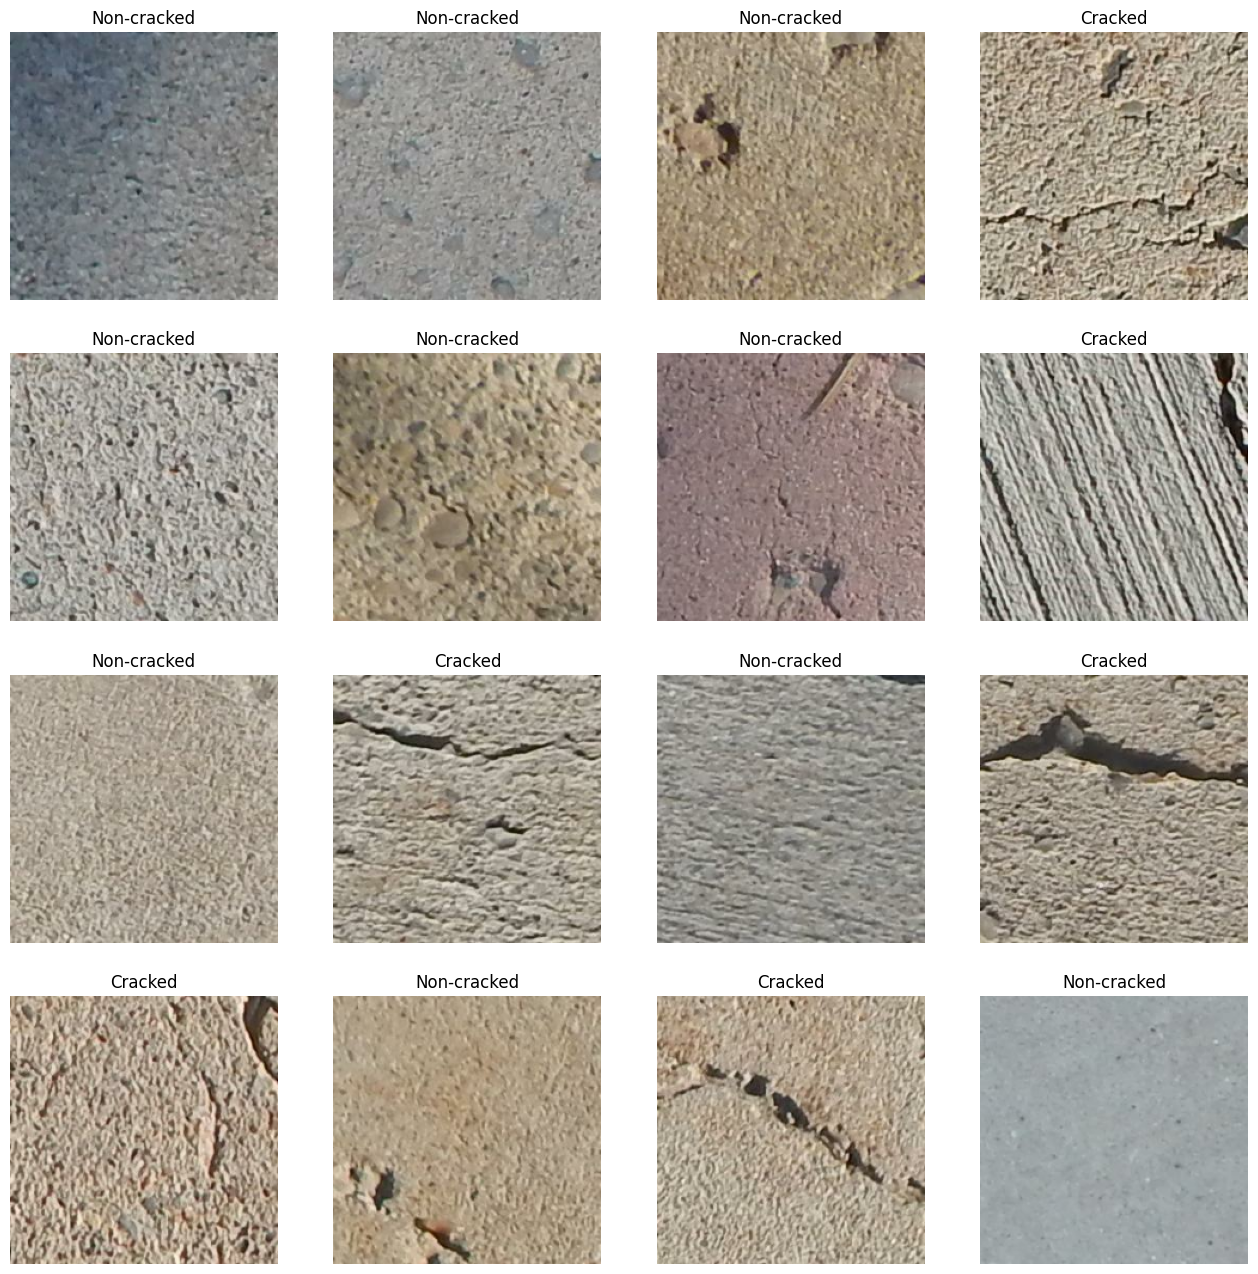

In [16]:
plt.figure(figsize=(16, 16))
for images, labels in balanced_train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in balanced_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


The image_batch is a tensor of the shape (16, 224, 224, 3). This is a batch of 16 images of shape 224x224x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (16,), these are corresponding labels to the 16 images.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* Dataset.prefetch overlaps data preprocessing and model execution while training.
  
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

balanced_train_ds = balanced_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
balanced_val_ds = balanced_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build and Train the Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomWidth, RandomHeight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Model 1

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). 

In [20]:
first_filters = 16
second_filters = 32
third_filters = 64
kernel_size = (3,3)
pool_size= (2,2)

model1 = Sequential([
  Rescaling(1./255, input_shape = (img_height, img_width, 3)), # Standardize values to be in the [0, 1] range 
  Conv2D(first_filters, kernel_size, activation='relu'),
  MaxPooling2D(pool_size = pool_size),
    
  Conv2D(second_filters, kernel_size, activation='relu'),
  MaxPooling2D(pool_size = pool_size),
    
  Conv2D(third_filters, kernel_size, activation='relu'),
  MaxPooling2D(pool_size = pool_size),
    
  Flatten(),
  Dense(128, activation='relu'),
  Dense(1, activation = "sigmoid")
])
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,537,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,561,633 (21.22 MB)

 Trainable params: 5,561,633 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile the model
model1.compile(Adam(0.001), loss = "binary_crossentropy", metrics=["accuracy"])

In [22]:
epochs = 10
history1 = model1.fit(
              balanced_train_ds,
              validation_data = balanced_val_ds,
              epochs = epochs
            )

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.5602 - loss: 0.8356 - val_accuracy: 0.5996 - val_loss: 0.6545
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6760 - loss: 0.6184 - val_accuracy: 0.6203 - val_loss: 0.6448
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7079 - loss: 0.5699 - val_accuracy: 0.6390 - val_loss: 0.6306
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7487 - loss: 0.5116 - val_accuracy: 0.6763 - val_loss: 0.5952
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7815 - loss: 0.4615 - val_accuracy: 0.7106 - val_loss: 0.6279
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8224 - loss: 0.3801 - val_accuracy: 0.7075 - val_loss: 0.7577
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8540 - loss: 0.3363 - val_accuracy: 0.7106 - val_loss: 0.8293
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8727 - loss: 0.3010 - val_acc

### Visualize Training Results

Create plots of the loss and accuracy on the training and validation sets:

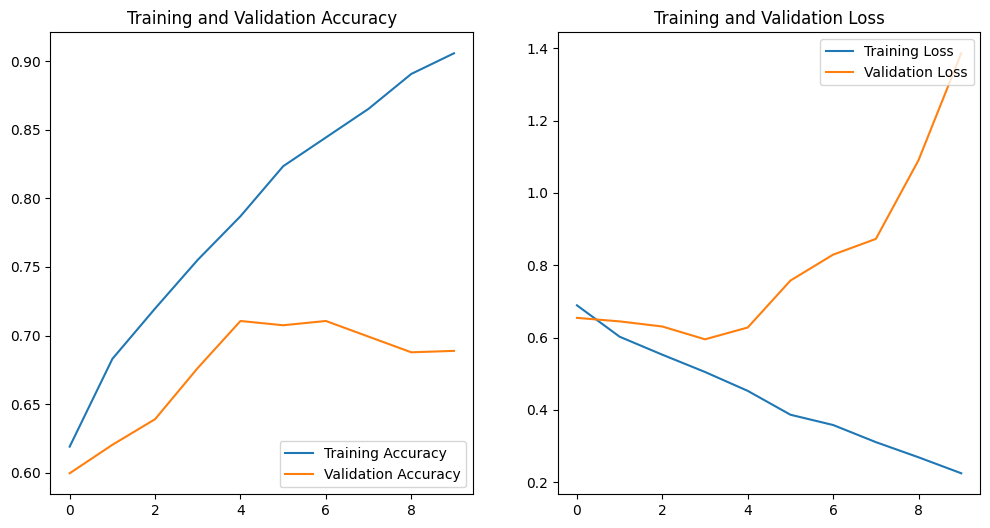

In [23]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model1_hist = pd.DataFrame(model1.history.history)
max_val_acc1 = model1_hist.val_accuracy.max()
print('Maximum Validation Acc:', round(max_val_acc1 * 100, 2), "%")
min_val_loss1 = model1_hist.val_loss.min()
print('Minimum Validation Loss:', round(min_val_loss1 * 100, 2), "%")

Maximum Validation Acc: 71.06 %
Minimum Validation Loss: 59.52 %


In [25]:
# Save the model
model1.save('model1.keras')

The plots show that training accuracy is increasing linearly over epoches but validation accuracy is direverted away. Similarly, the loss of training data decreases all the way to the end but loss of validation diverted away at in the middle. These are signs of overfitting. 

I will be using data augmentation to generate believeable-looking images. This helps expose the model to more aspects of the data and generalize better. Another techinique utilized to reduce overfitting is dropout.

In [26]:
data_augmentation = Sequential(
  [
    RandomFlip("horizontal",
                input_shape=(img_height,
                            img_width,
                            3)),
    RandomRotation(0.2),
    RandomZoom(0.2)
    # RandomHeight(0.2),
    # RandomWidth(0.2),
  ]
)

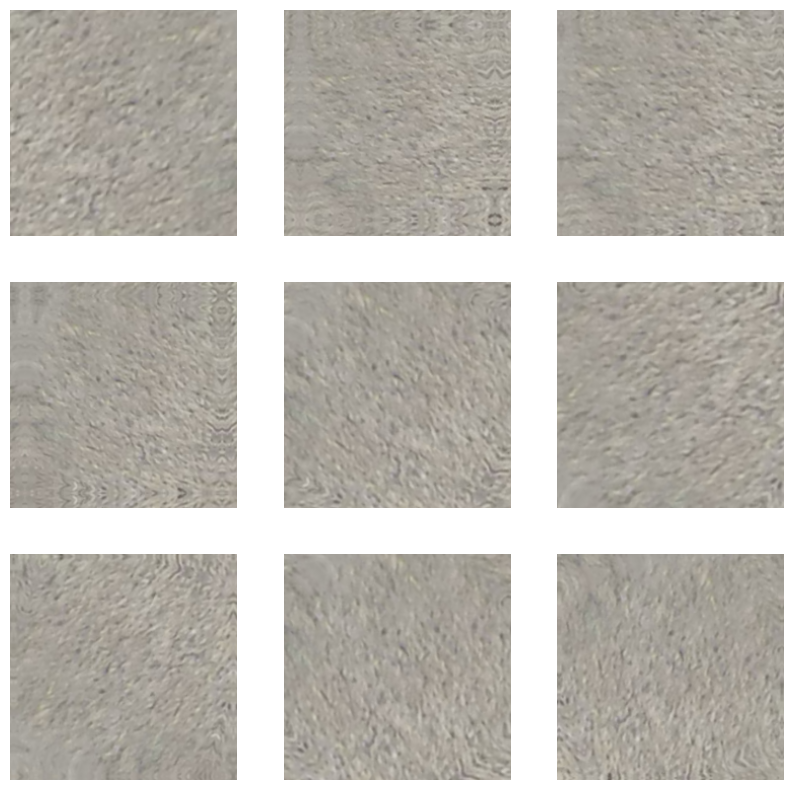

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model 2

In [28]:
first_filters = 16
second_filters = 32
third_filters = 64
kernel_size = (3,3)
pool_size= (2,2)
dropout_dense = 0.4

model2 = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(first_filters, kernel_size, activation='relu'),
  MaxPooling2D(pool_size = pool_size),
    
  Conv2D(second_filters, kernel_size, activation='relu'),
  MaxPooling2D(pool_size = pool_size),
    
  Conv2D(third_filters, kernel_size, activation='relu'),
  MaxPooling2D(pool_size = pool_size),
    
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(dropout_dense),
  Dense(1, activation = "sigmoid")
])
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       5,537,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,561,633 (21.22 MB)

 Trainable params: 5,561,633 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
model2.compile(Adam(0.001), loss = "binary_crossentropy", metrics=["accuracy"])

In [30]:
epochs = 10

# early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3, 
#                            verbose = 1, mode = 'max', restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [reduce_lr]

history2 = model2.fit(
              balanced_train_ds,
              validation_data = balanced_val_ds,
              epochs = epochs,
              callbacks=callbacks_list
            )

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5366 - loss: 0.8916 - val_accuracy: 0.6380 - val_loss: 0.6758 - learning_rate: 0.0010
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5625 - loss: 0.6878 - val_accuracy: 0.6172 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5208 - loss: 0.6949
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5208 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5175 - loss: 0.6926 - val_accuracy: 0.5010 - val_loss: 0.6927 - learning_rate: 5.0000e-04
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5403 - loss: 0.6855 - val_accuracy: 0.6483 - val_loss: 0.6450 - learning_rate: 5.0000e-04
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6213 - l

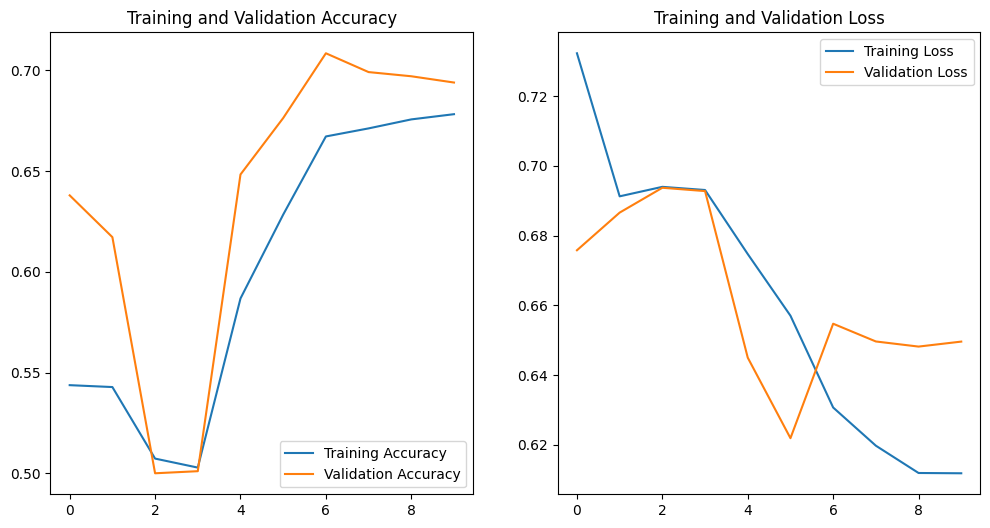

In [31]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']


loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
model2_hist = pd.DataFrame(model2.history.history)
max_val_acc2 = model2_hist.val_accuracy.max()
print('Maximum Validation Acc:', round(max_val_acc2 * 100, 2), "%")
min_val_loss2 = model2_hist.val_loss.min()
print('Minimum Validation Loss:', round(min_val_loss2 * 100, 2), "%")

Maximum Validation Acc: 70.85 %
Minimum Validation Loss: 62.19 %


After applying data augmentation and Dropout, there is less overfitting than before, and both of the accuray and loss for training and validation are closer aligned. However, the accuracy and loss of the second models are not as good as expected.

In [33]:
# Save the model
model2.save('model2.keras')

## Model 3

I deployed EfficientNetB0 CNN architecture mentioned in [Concrete Cracks Detection Using Convolutional NeuralNetwork Based on Transfer Learning](https://onlinelibrary.wiley.com/doi/10.1155/2020/7240129).

The EfficientNet-B0 network consists of three sections: Stem, Body and Head.
1. Stem:
   * Initial layer with a standard convolution followed by a batch normalization and a ReLU6 activation.
   * Convolution with 32 filters, kernel size 3x3, stride 2.
2. Body:
   * Consists of a series of MBConv blocks with different configurations
   * Each block includes depthwise separable convolutions and squeeze-and-excitation layers.
   * Example configuration for MBConv block:
        * Expansion ratio: The factor by which the input channels are expanded.
        * Kernel size: Size of the convolutional filter.
        * Stride: The stride length for convolution.
        * SE ratio: Ratio for squeeze-and-excitation.
4. Head:
    * Includes a final convolutional block, followed by a global average pooling layer.
    * A fully connected layer with a softmax activation function for classification.

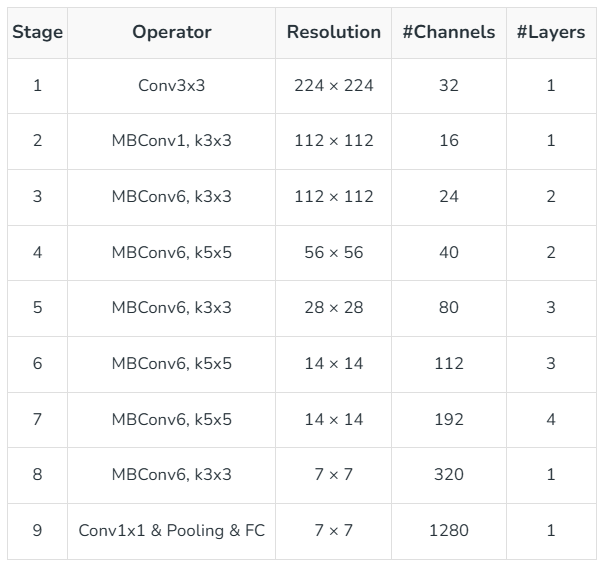

Reference: https://www.geeksforgeeks.org/efficientnet-architecture/

In [34]:
from tensorflow.keras.applications import EfficientNetB0

model3 = EfficientNetB0(include_top=False)
model3.trainable = False
# Create the model architecture with trainable top layers
inputs = Input(shape = (224, 224, 3), name = 'input_layer')
# Add the data augmentation layer
x = data_augmentation(inputs)
x = model3(x, training = False)
x = GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)
# outputs = Dense(2, activation = 'softmax', name = 'output_layer')(x)
outputs = Dense(1, activation = 'sigmoid', name = 'output_layer')(x)
model3 = tf.keras.Model(inputs, outputs)
model3.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [35]:
# Compile the model
model3.compile(Adam(0.001), loss = "binary_crossentropy", metrics=["accuracy"])
# model3.compile(Adam(0.001), loss = "categorical_crossentropy", metrics=["accuracy"])

In [36]:
epochs = 20

# early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3, 
#                            verbose = 1, mode = 'max', restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [reduce_lr]

history3 = model3.fit(
              balanced_train_ds,
              validation_data = balanced_val_ds,
              epochs = epochs,
              callbacks=callbacks_list
            )

Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.7057 - loss: 0.5853 - val_accuracy: 0.7884 - val_loss: 0.4636 - learning_rate: 0.0010
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7749 - loss: 0.4882 - val_accuracy: 0.8164 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7764 - loss: 0.4617 - val_accuracy: 0.8205 - val_loss: 0.4077 - learning_rate: 0.0010
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7872 - loss: 0.4504 - val_accuracy: 0.8216 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7919 - loss: 0.4423 - val_accuracy: 0.8257 - val_loss: 0.3872 - learning_rate: 0.0010
Epoch 6/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7905 - loss: 0.4447 - val_accuracy: 0.8278 - val_loss: 0.3849 - learning_rate: 0.0010
Epoch 7/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8039 - l

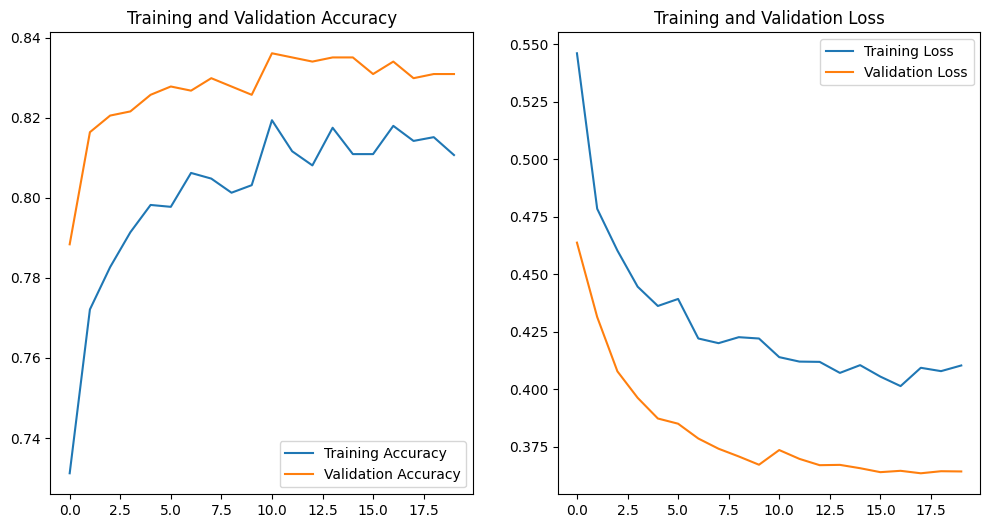

In [37]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
max_val_acc3 = np.max(val_acc)
print('Maximum Validation Acc:', round(max_val_acc3 * 100, 2), "%")
min_val_loss3 = np.min(val_loss)
print('Minimum Validation Loss:', round(min_val_loss3 * 100, 2), "%")

Maximum Validation Acc: 83.61 %
Minimum Validation Loss: 36.34 %


In [39]:
# Save the model
model3.save('model3.keras')

## Results

In [40]:
y_pred1 = model1.predict(balanced_val_ds, steps=len(balanced_val_ds), verbose=1)
# Convert probabilty to 0 or 1
yp1 = [1 if yp >= 0.5 else 0 for yp in y_pred1]
# Access Labels from a tf.data.Dataset
test_label = [labels.numpy() for images, labels in balanced_val_ds.unbatch()]

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


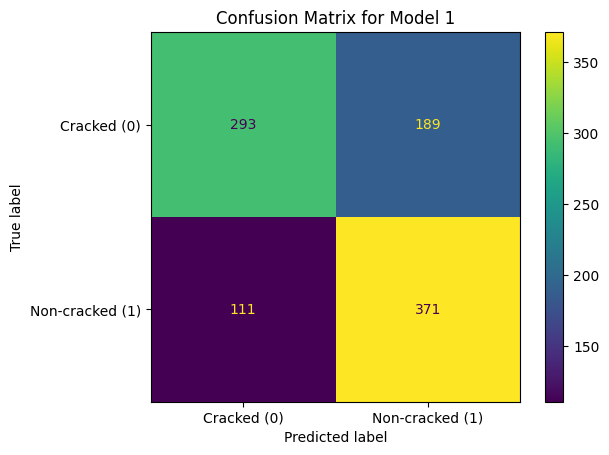

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['Cracked (0)', 'Non-cracked (1)']
cm = confusion_matrix(test_label, yp1)
cmd = ConfusionMatrixDisplay(cm, display_labels = labels)
cmd.plot()
plt.title('Confusion Matrix for Model 1')
plt.grid(False)
plt.show()

$Precision = TP/(TP+FP)$

$Recall = TP/(TP+FN)$

$F1 = 2 * Precision * Recall/(Precision + Recall)$
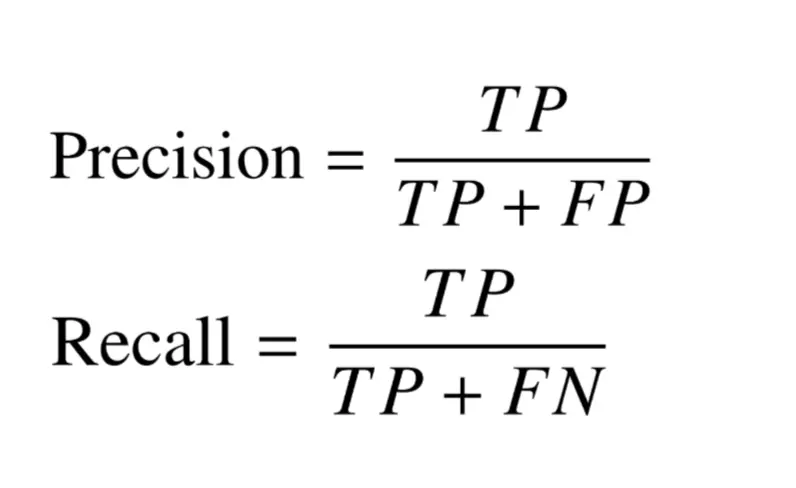
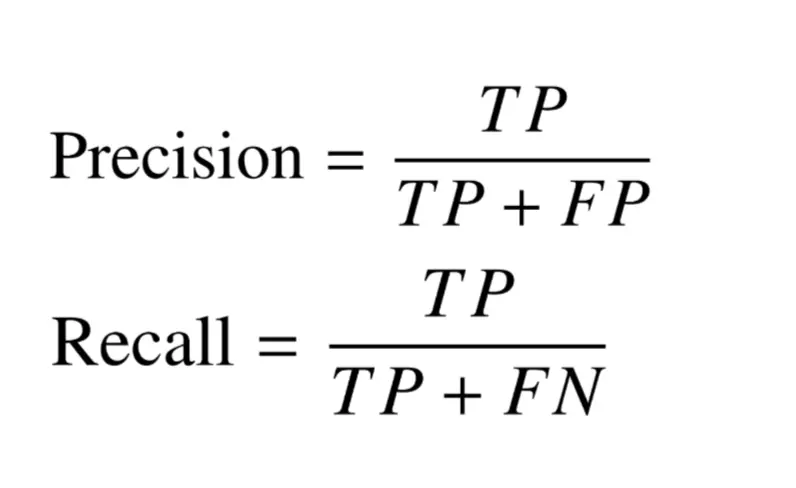
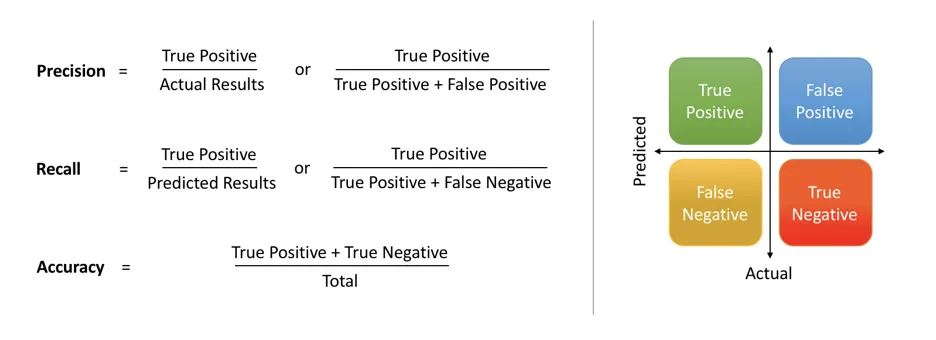
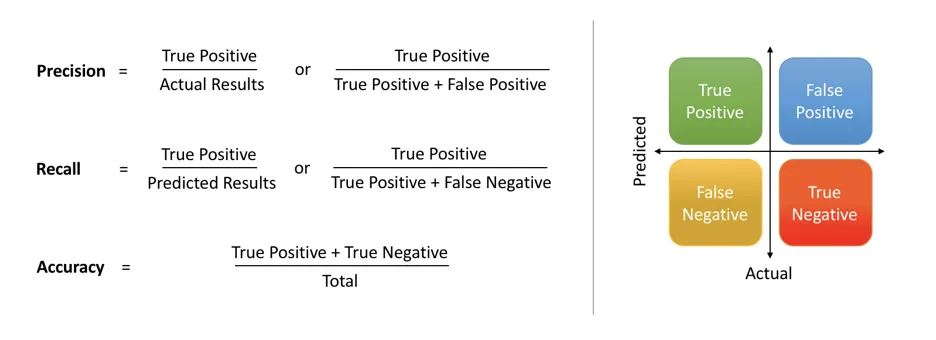

In [42]:
# Display a classification report
from sklearn.metrics import classification_report
print(classification_report(test_label, yp1, target_names=labels))

                 precision    recall  f1-score   support

    Cracked (0)       0.73      0.61      0.66       482
Non-cracked (1)       0.66      0.77      0.71       482

       accuracy                           0.69       964
      macro avg       0.69      0.69      0.69       964
   weighted avg       0.69      0.69      0.69       964



In [43]:
y_pred2 = model2.predict(balanced_val_ds, steps=len(balanced_val_ds), verbose=1)
# Convert probabilty to 0 or 1
yp2 = [1 if yp >= 0.5 else 0 for yp in y_pred2]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


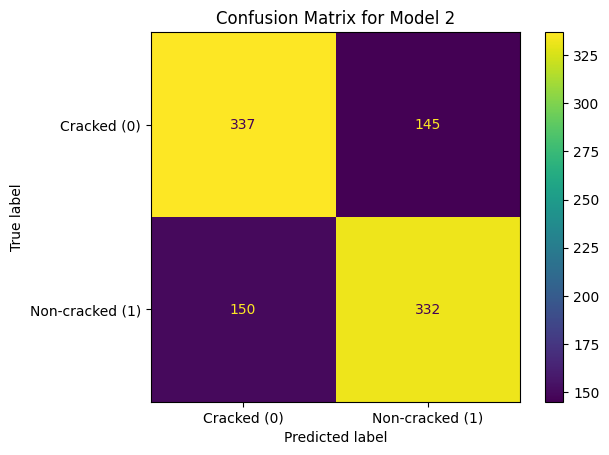

In [44]:
labels = ['Cracked (0)', 'Non-cracked (1)']
cm = confusion_matrix(test_label, yp2)
cmd = ConfusionMatrixDisplay(cm, display_labels = labels)
cmd.plot()
plt.title('Confusion Matrix for Model 2')
plt.grid(False)
plt.show()

In [45]:
# Display a classification report
print(classification_report(test_label, yp2, target_names=labels))

                 precision    recall  f1-score   support

    Cracked (0)       0.69      0.70      0.70       482
Non-cracked (1)       0.70      0.69      0.69       482

       accuracy                           0.69       964
      macro avg       0.69      0.69      0.69       964
   weighted avg       0.69      0.69      0.69       964



In [46]:
y_pred3 = model3.predict(balanced_val_ds, steps=len(balanced_val_ds), verbose=1)
# Convert probabilty to 0 or 1
yp3 = [1 if yp >= 0.5 else 0 for yp in y_pred3]

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step


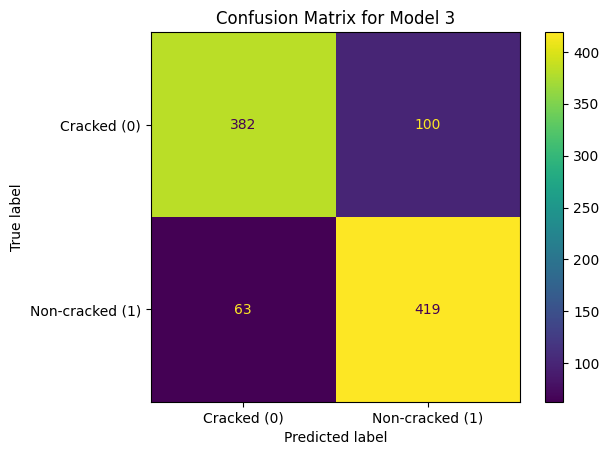

In [47]:
labels = ['Cracked (0)', 'Non-cracked (1)']
cm = confusion_matrix(test_label, yp3)
cmd = ConfusionMatrixDisplay(cm, display_labels = labels)
cmd.plot()
plt.title('Confusion Matrix for Model 3')
plt.grid(False)
plt.show()

In [48]:
# Display a classification report
print(classification_report(test_label, yp3, target_names=labels))

                 precision    recall  f1-score   support

    Cracked (0)       0.86      0.79      0.82       482
Non-cracked (1)       0.81      0.87      0.84       482

       accuracy                           0.83       964
      macro avg       0.83      0.83      0.83       964
   weighted avg       0.83      0.83      0.83       964



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


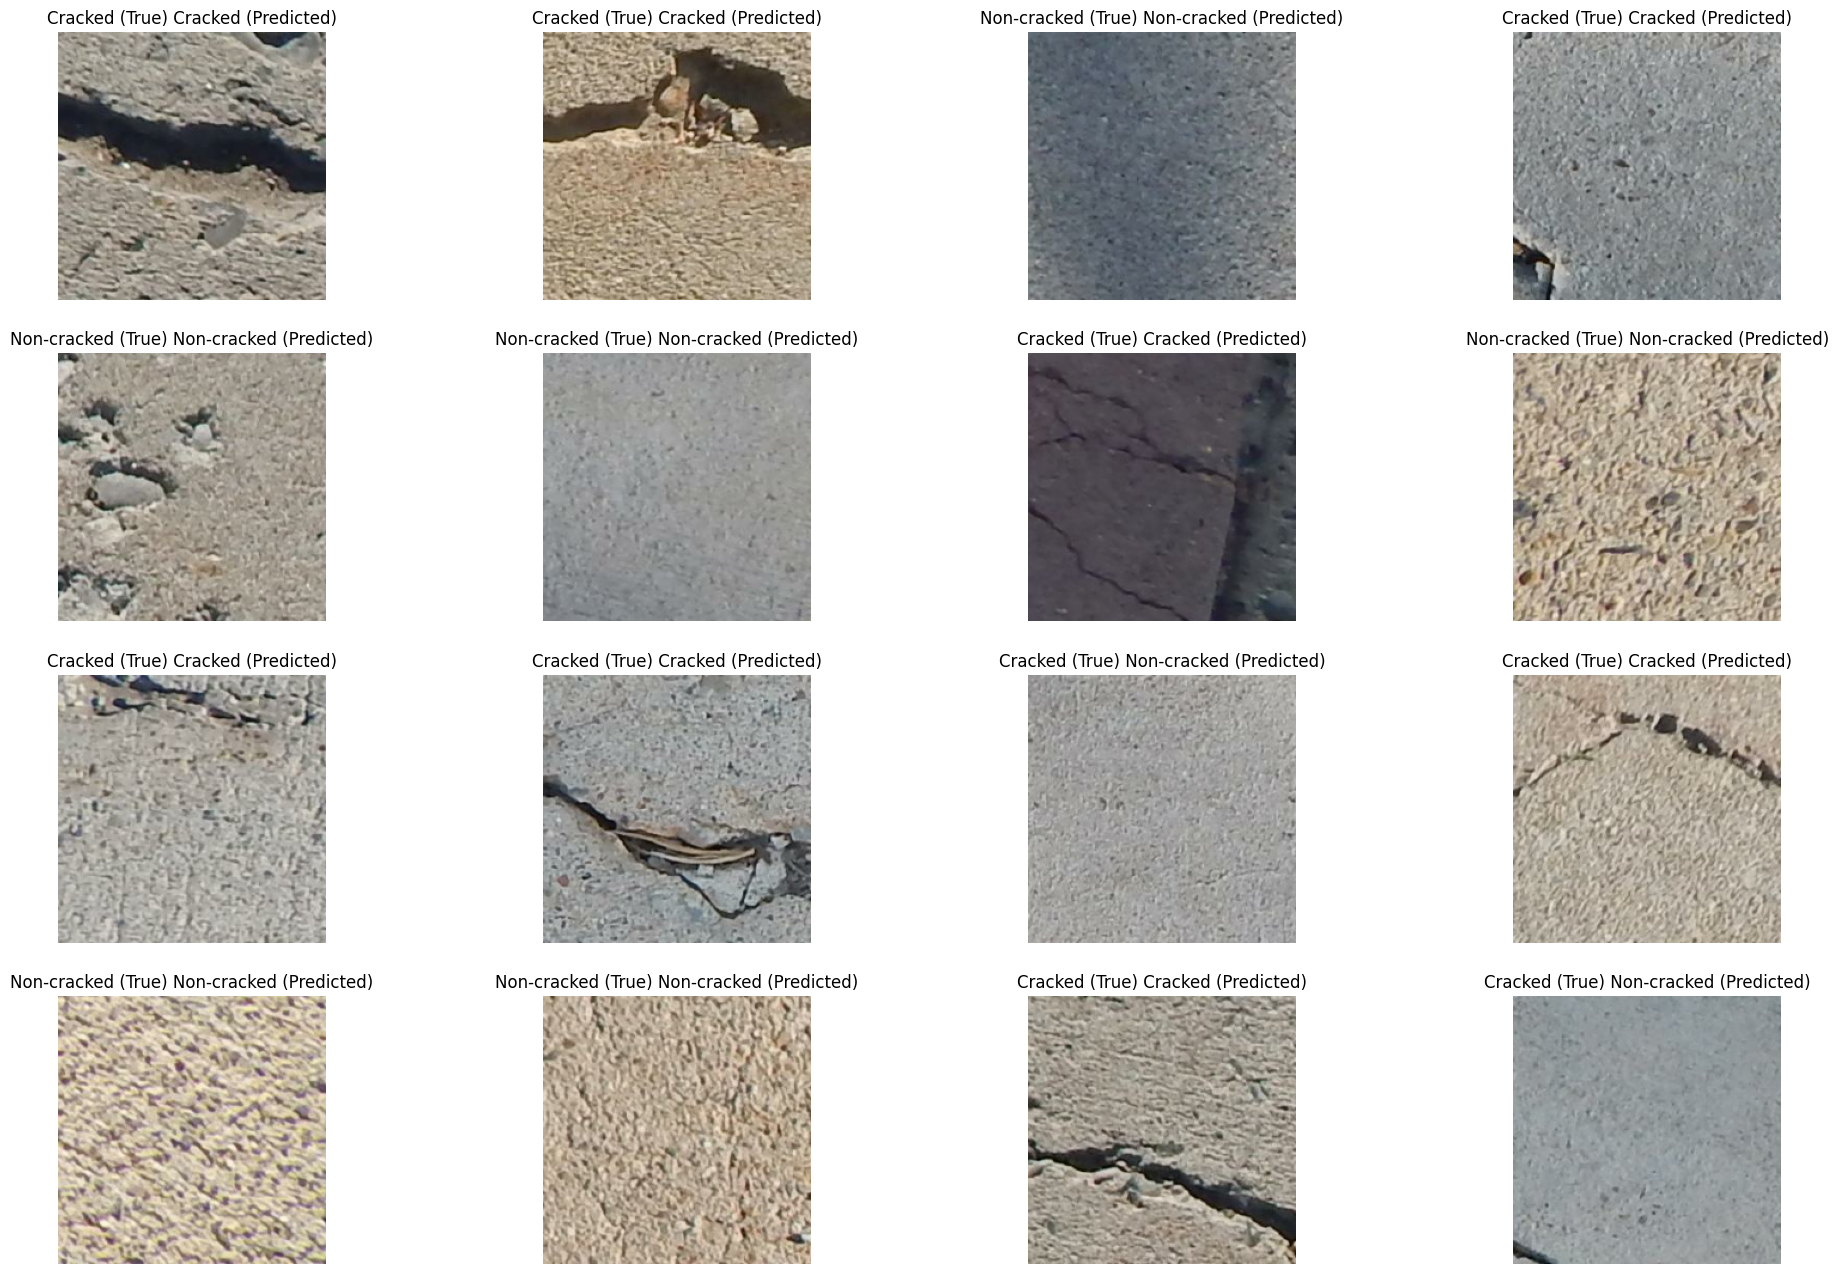

In [49]:
# Visualized Prediction Results
plt.figure(figsize=(24, 16))
for images, labels in balanced_val_ds.take(1):
  y_p = model3.predict(balanced_val_ds.take(1)) 
  y_p = [1 if y >= 0.5 else 0 for y in y_p]
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]] + ' (True) ' + class_names[y_p[i]] + ' (Predicted)')
    plt.axis("off")

## Conclusion

In this project, I built and trained three convolutinoal neural network models to detect cracks in concrete from pavements image. The dataset is Structural Defects Network (SDNET) 2018 provided by Utah State University stored in Kaggle.


Model 1 is composed of three convolutional blocks (Conv2D), each paired with a max pooling layer (MaxPooling2D). Model 1 has decent accuracy and loss. However, these metrics on training dataset do not align with validation dataset. Model 2 utilized similarly architecture as model 1. Data  augmentation and dropout layers are added to address the overfitting issue. It has both training and validation metrics close align but the accuracy, under 70%, is mediocre. Model 3 using EfficientNetB0 has better accuracy, 81% in training and 83% in validation, and relatively lower loss. Moreover, the model performance on training and validation data is close aligned. Therefore, model 3 with EfficientNetB0 architecture is the best model.

Looking at classification metrics in the report of model 3, there is still room for improvement, particularly in the recall for detecting cracks. The recall of 0.78 indicating there is around 22% false negative cases. In the other words, there are 22% cracks in images did not identified by the model 3. From the perspective of pavement rehabilitation, the recall is more critical than precision as owners generally prioritize not missing cracks, even if it means overestimating their number. 

There are several strategies I plan to explore to further improve the performance of the CNN model. Firstly, I will explore additional methods for fine-tuning the EfficientNetB0 model. Additionally, I plan to investigate alternative models by reviewing related research on crack detection using CNNs.

In summary, while my initial models offer valuable insights into crack identification in the image, there is ample potential for further enhancement. 

## Reference

* https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset
* https://onlinelibrary.wiley.com/doi/10.1155/2019/6520620
* https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5
* https://onlinelibrary.wiley.com/doi/10.1155/2020/7240129
* https://www.kaggle.com/code/gorkemgul/natural-scene-classifier-using-efficientnetb0#%F0%9F%93%9D-Data-Preparation
* https://www.geeksforgeeks.org/efficientnet-architecture/